<br>

# Ripple-associated amplitude changes

The forth notebook is used to analyse putative ripple-associated CG amplitude changes (that is, during hippocampal ripple occurrence) in different task contexts. It does so by:

- Plotting the averaged amplitude (uV) before and after ripple occurrence during different task phases or contexts;
- Plotting amplitude for all SWR events in a heatmap;
- Significance testing of observed changes to baseline. Test used:

<br>

### Imports

In [40]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

<br>

### Open datasets

In [90]:
main_path = 'PreProcessedData/'
cg_data = pd.read_csv(os.path.join(main_path, 'cg_data.csv'), index_col=False)
ripple_data = pd.read_csv(os.path.join(main_path, 'cg_analysis_ripple_library.csv'), index_col=False)

<br>

### Inspect dataset

In [15]:
cg_data.head()

,ripple_nr,timestamp,TT1,TT2,TT3,TT4,TT5,TT6,TT7,TT8,TT9,TT10,TT11,TT12,TT13,TT14,start_time,phase,relative_timestamp
0,0,83.25725,151.905,105.105,158.730,191.685,-38.610,121.485,115.245,146.835,149.760,147.225,8.970,73.905,37.830,70.590,83.75725,Sample,-0.5000
1,0,83.25775,144.495,125.190,151.515,148.980,-86.775,116.415,108.420,145.470,145.080,130.455,7.020,70.785,44.070,67.275,83.75725,Sample,-0.4995
2,0,83.25825,76.440,95.940,108.420,106.470,-139.620,68.250,33.150,111.735,109.590,75.855,-79.755,15.405,12.870,23.010,83.75725,Sample,-0.4990
3,0,83.25875,0.000,17.160,54.990,18.525,-220.155,-26.715,-52.455,40.365,65.520,-0.780,-129.870,-38.610,-71.955,-40.365,83.75725,Sample,-0.4985
4,0,83.25925,-20.280,-10.920,28.665,15.795,-262.470,-54.015,-74.685,16.380,18.915,-39.585,-130.650,-69.615,-82.485,-88.140,83.75725,Sample,-0.4980


In [16]:
cg_data.ripple_nr.nunique()

628

<br>

### Perform transformations on dataset 

##### Tranform to long format

In [23]:
tt_columns=['TT{}'.format(x) for x in range(1,14)]

In [30]:
data = cg_data.melt(
    id_vars=['ripple_nr', 'timestamp', 'relative_timestamp', 'start_time', 'phase'],
    value_vars=tt_columns,
    var_name = 'TT',
    value_name='voltage'
)

#### Define relative time bins with bin centers to plot

In [120]:
# defining the bin edges (can't use range with floats)
bins=[float(x/100) for x in [*range(-51, 51, 1)]]
# bin the relative timestamp column (10 ms bins)
data['bins'] = pd.cut(data['relative_timestamp'], bins)
data["bin_centres"] = data["bins"].apply(lambda x: x.mid)

In [121]:
data

,ripple_nr,timestamp,relative_timestamp,start_time,phase,TT,voltage,bins,bin_centres
0,0,83.257250,-0.500000,83.757250,Sample,TT1,151.905,"(-0.51, -0.5]",-0.505
1,0,83.257750,-0.499500,83.757250,Sample,TT1,144.495,"(-0.5, -0.49]",-0.495
2,0,83.258250,-0.499000,83.757250,Sample,TT1,76.440,"(-0.5, -0.49]",-0.495
3,0,83.258750,-0.498500,83.757250,Sample,TT1,0.000,"(-0.5, -0.49]",-0.495
4,0,83.259250,-0.498000,83.757250,Sample,TT1,-20.280,"(-0.5, -0.49]",-0.495
...,...,...,...,...,...,...,...,...,...
23346084,627,266.930000,0.498667,266.431333,Sample,TT13,-0.195,"(0.49, 0.5]",0.495
23346085,627,266.930333,0.499000,266.431333,Sample,TT13,23.205,"(0.49, 0.5]",0.495
23346086,627,266.930667,0.499333,266.431333,Sample,TT13,39.975,"(0.49, 0.5]",0.495
23346087,627,266.931000,0.499667,266.431333,Sample,TT13,39.585,"(0.49, 0.5]",0.495


<br>

### Plot averaged amplitude changes

[Seaborn point plot](https://seaborn.pydata.org/generated/seaborn.pointplot.html)

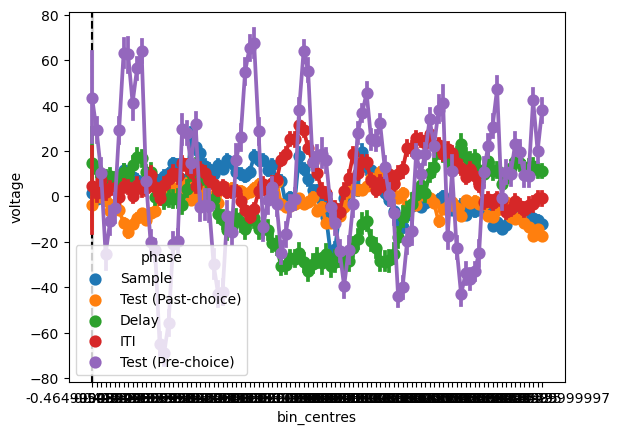

In [126]:
g = sns.pointplot(
    data = data,
    x ='bin_centres', 
    y ='voltage',
    hue='phase',
    errorbar = 'ci'
)

# Add vertical bar to SWR onset (relative_timestamp = 0)
g.axvline(x=0, color='black', linestyle='--')  #Need to fix
# Add shadowed area for baseline (pre-ripple)
plt.axvspan(xmin= -0.2, xmax= -0.001, color='gray', alpha=0.2)
# Add shadowed area for post-ripple
plt.axvspan(xmin=0.001, xmax=0.2, color='gray', alpha=0.2)

<br> 

### Test changes to baseline

- Comparing pre-ripple (baseline) and post-ripple amplitude changes 